# <p style="text-align: center;">Learning about the Attention Mechanism and the Transformer Model</p>
## <p style="text-align: center;">Baptiste Amato, Alexis Durocher, Gabriel Hurtado, Alexandre Jouandin, Vincent Marois</p>
### <p style="text-align: center;">Georgia Tech - Spring 2019 CS 7643 Deep Learning Class Project - Prof. Zsolt Kira</p>

# TEMPLATE HERE: 
https://www.cc.gatech.edu/classes/AY2019/cs7643_spring/assets/project_webpage_template/

<p style="text-align: center; font-weight: bold;">Abstract</p>

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.



# Teaser figure

Here is an image of the `Transformer` architecture, drawn from [here](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html):

<img alt='The Transformer architecture and a zoom on the attention mechanism' src='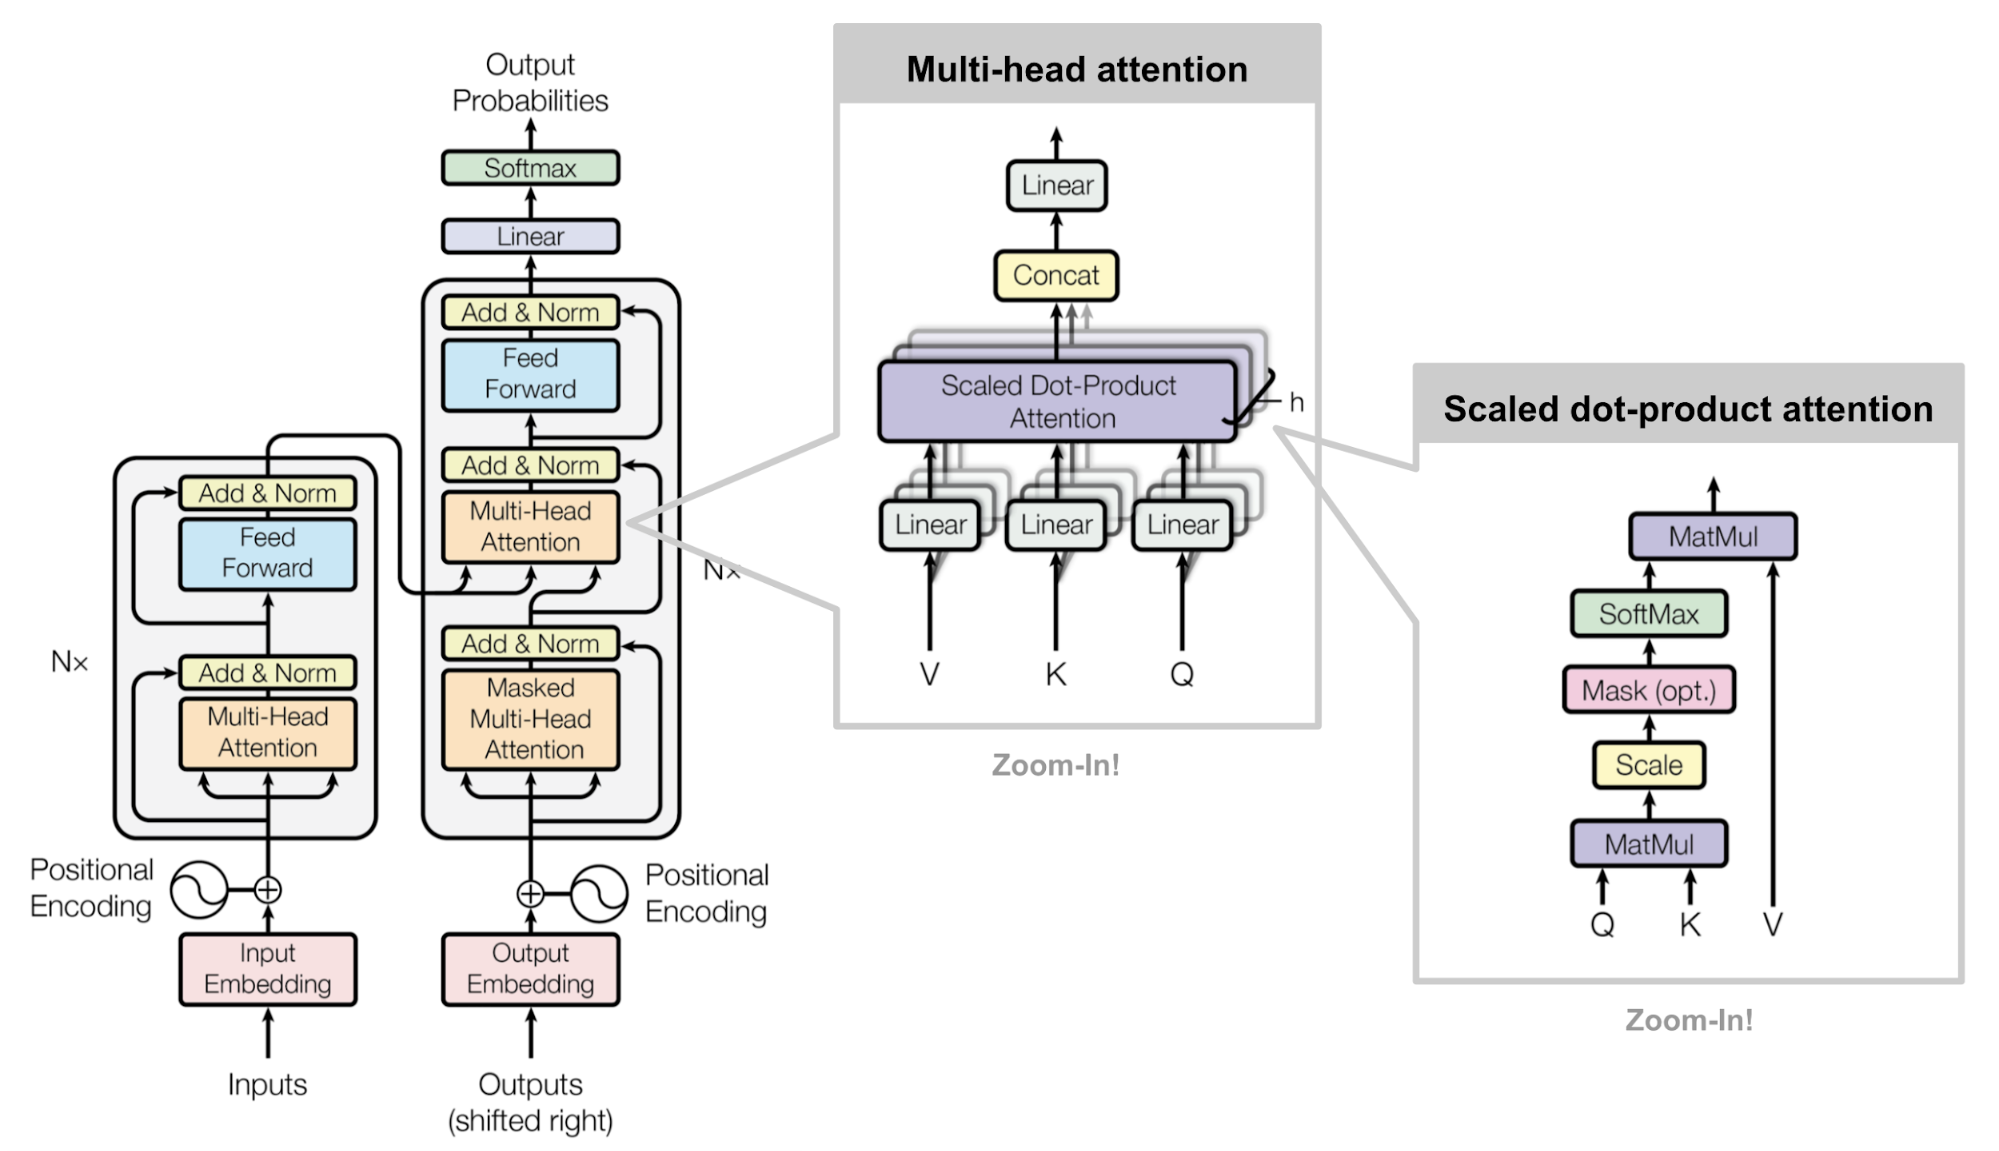
'></img>

# Introduction, Background and Motivation

The `Transformer` model, published in 2017 by Vaswani et al. has established state-of-the-art results in translation, using an Encoder-Decoder architecture which does not present recurrence, breaking with previously established models (the same motivation can be found in other models, such as ConvS2S ([cite](https://arxiv.org/abs/1705.03122)) and ByteNet ([cite](https://arxiv.org/abs/1610.10099))), supposedly yielding major improvements in computational complexity.

Additionally, it only relies on the attention mechanism ([cite](https://arxiv.org/abs/1409.0473)) to compute representations of its inputs and outputs. Intrinsically, this makes it an exciting problem to study. Moreover, several new models using its architecture have been published (Universal Transformers ([cite](https://arxiv.org/abs/1807.03819)), OpenAI's GPT-2 ([cite](https://openai.com/blog/better-language-models/)), and more recently their Sparse Transformer ([cite](https://arxiv.org/abs/1904.10509))), reinforcing its interest as a robust neural brick for complex models.

Yet, while the paper is clearly written, several questions come to mind when reading it, and designing its implementation:

- _Is the model's behavior identical during training and inference? Indeed, given that the model is not recurrent, can it perform greedy decoding (i.e. step-by-step prediction of the next word, starting from an initial token)?_
- _What are the mechanisms of the model to replace recurrence, if any?_
- _What is the sensibility of the model's training to hyper-parameters?_
- _Can the results shown in the paper be reproduced, or approached, with limited time and computational resources?_


_What problem did you try to solve?_

Therefore, the problem we are tackling in this project is centered around the issue of _reproducibility_. This question has recently been tracting more attention from the research community (for instance, a [workshop](https://sites.google.com/view/icml-reproducibility-workshop/home) at ICLR 2019 is dedicated to it), and is thus a valid research question.

_What did you try to do?_ Our objectives were thus to:

- Deeply understand the architecture of the `Transformer `model,
- Reimplement (correctly) the `Transformer` model,
- Reproduce its training process and have the model converging to acceptable results,
- Answer the above questions, i.e. provide additional _food for thoughts_ on the model to the research community, from our student's perspective.


_How is it done today, and what are the limits of current practice?_

Several references can be indicated here:

- The original paper, from Vaswani et al., published at NIPS 2017. They implemented the model in the `tensor2tensor` framework ([cite](http://arxiv.org/abs/1803.07416), now part of `Tensorflow`), and trained it for 3.5 days on 8 GPUs. A limitation here is thus in terms of available computing resources. Realistically, we are not able to get access to similar machines, which motivates a deeper analysis of the training procedure, to understand which characteristics are necessary, and others optional.
- [The Annotated `Transformer`](http://nlp.seas.harvard.edu/2018/04/03/attention.html) from Harvard's NLP group. This is an detailed walkthrough of the original paper, with code snippets showing how to implement the model's architecture. While this is a great resource to _understand_ the model, its limitations concerns the training process. Indeed, it was not designed to perform a hyper-parameter search, or to be deployed on GPU instances for training. Thus, this will be an additional focus for us.
- The `Transformer` is a relatively popular model, and several repositories propose a reimplementation in diverse frameworks (a rapid search show ~150 repositories existing on GitHub).


_Who cares? If you are successful, what difference will it make?_

While we, from a realistic point of view, do not expect to propose significant improvements on the `Transformer` architecture, we do hope to provide significants insights on the model, its training & inference behavior, as well as a basis for further investigations. For instance, we have implement an hyper-parameter search (for both the training's parameters and the model structure): we hope this will serve to the _research community_ for future models based on the `Transformer`.

The code repository can be found [here]().

# Approach

We can now detail our approach.

_What did you do exactly? How did you solve the problem? Why did you think it would be successful?_

## Initial implementation and test on the copy task

We started by implementing the model (using `PyTorch` v1.0), dividing each architectural blocks (`EncoderLayer`, `DecoderLayer`, `MultiHeadAttention`, `ResidualConnection` etc.) into classes, and ensured all were passing simple unit tests (i.e. verifying the shape of the output of the forward pass, the absence of `NaN` etc.).

_Did the very first thing you tried work?_

This took about a week and half to finish. At this stage, we decided to ensure that the flow of the overall model (i.e. a stack of 6 `EncoderLayer`, connected to a stack of 6 `DecoderLayer`, each layer having several sub-blocks) was correct. Thus, we wanted to verify if the model was able to fully converge on a simple algorithmic task: copying its inputs to outputs.). Indeed, a working implementation a such a heavy model should encounter any issue copying inputs to outputs.

We thus created a dataset generating random algorithmic sequences and train the model on it. Doing so further helped us on 2 aspects of the training:

- Adapt the code for CUDA support. This requires several steps, such as loading the model into GPU memory, converting the input tensors to CUDA types etc.
- Debug the model. An aspect we initially struggled with was the use of masking in the model's forward pass. Masks are used for:
    - Masking out the padding elements in the batches. Indeed, a batch is constituted of several sequences (algorithmic or tokenized sentences), each having a different length. In order to have a fixed batch shape, the shorter sequences are padded with 0s to match the length of the longest one. A boolean mask is generated alongside the batch and passed to the model in order to hide padding elements.
    - Masking out subsequents elements of a sequence in the `Decoder`. As the model is not recurrent, the entire input sequence is passed at once in the `Encoder`, which does not cause problems (the model is thus able to learn how to relate words at different positions in the sentence). During training, the target sentence is fed to the `Decoder` (in a _teacher forcing_ approach). Nevertheless, in order to simulate _greedy decoding_ during training, but keep the advantage of the parallelism of the model, a mask is created so that elements at position `i` in a sequence cannot be related to elements at position `i+1` and above. This is done so that the performance during inference (which is obligatorily step-by-step, i.e. we iteratively feed the prediction of the model back into the input of the `Decoder`) is preserved.

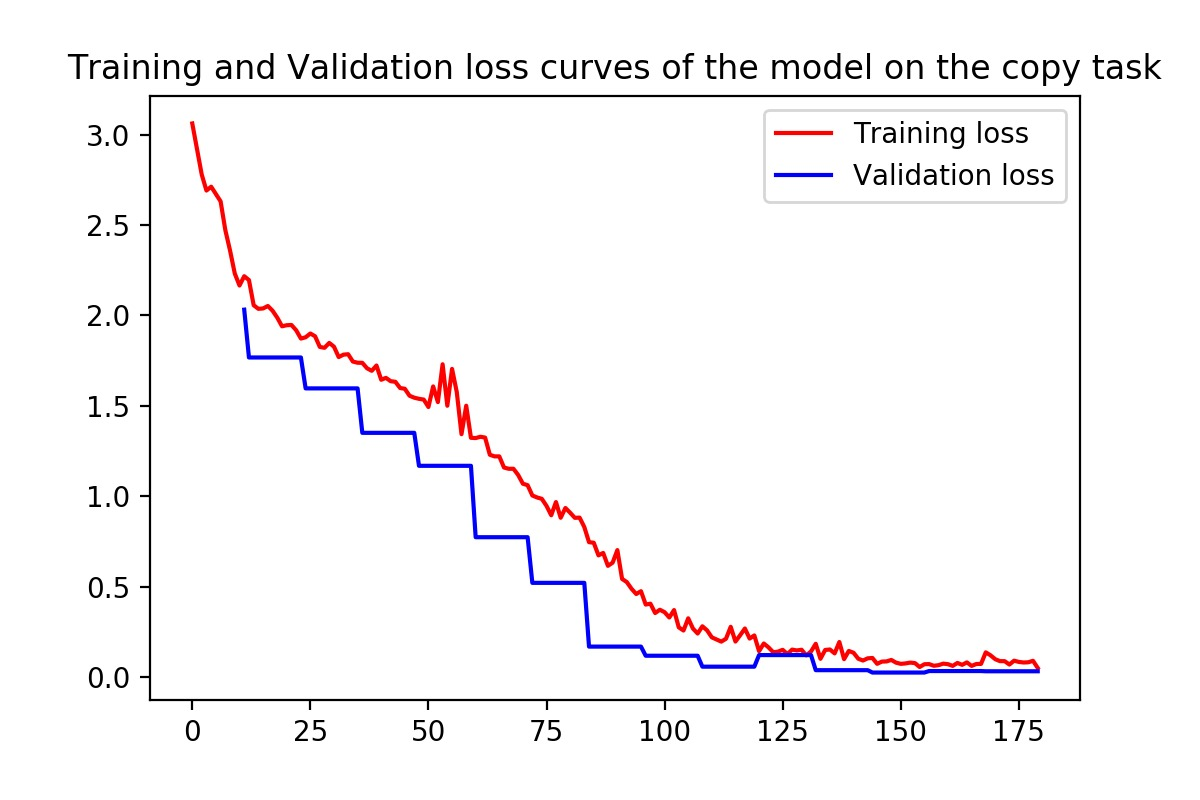</img>

<p style="text-align: center; font-weight: bold;">Figure 1: Training and Validation loss curves of the model on the copy task".</p>


As expected, the model was able to fully converge on this task, which gave us confidence that the model's forward pass was (_most likely_) correct.

## Training on the real dataset

We then processed to implement all missing requirements for the training:

- Collecting the statistics (loss, episode index etc.) to file and to TensorBoard,
- Implement the dataset and analyze it. We explain our approach below,
- Implement multi-GPU support (this is easily done using `PyTorch`'s `DataParallel` mechanism),
- Parameterize the training (specify a random seed, batch size etc.)
- Profile and try to reduce the memory usage of the model.


Analyzing the dataset delivered some interesting insights. For specifications, we used the IWSLT 2014 TED Translation dataset, with:

- 220k training samples, 1025 for validation, 1305 for test,
- Average sentence length: 20 (train) - 21 (val) - 19 (test),

Plotting the distribution of the samples with respect to the sequence length gave the following graphs:

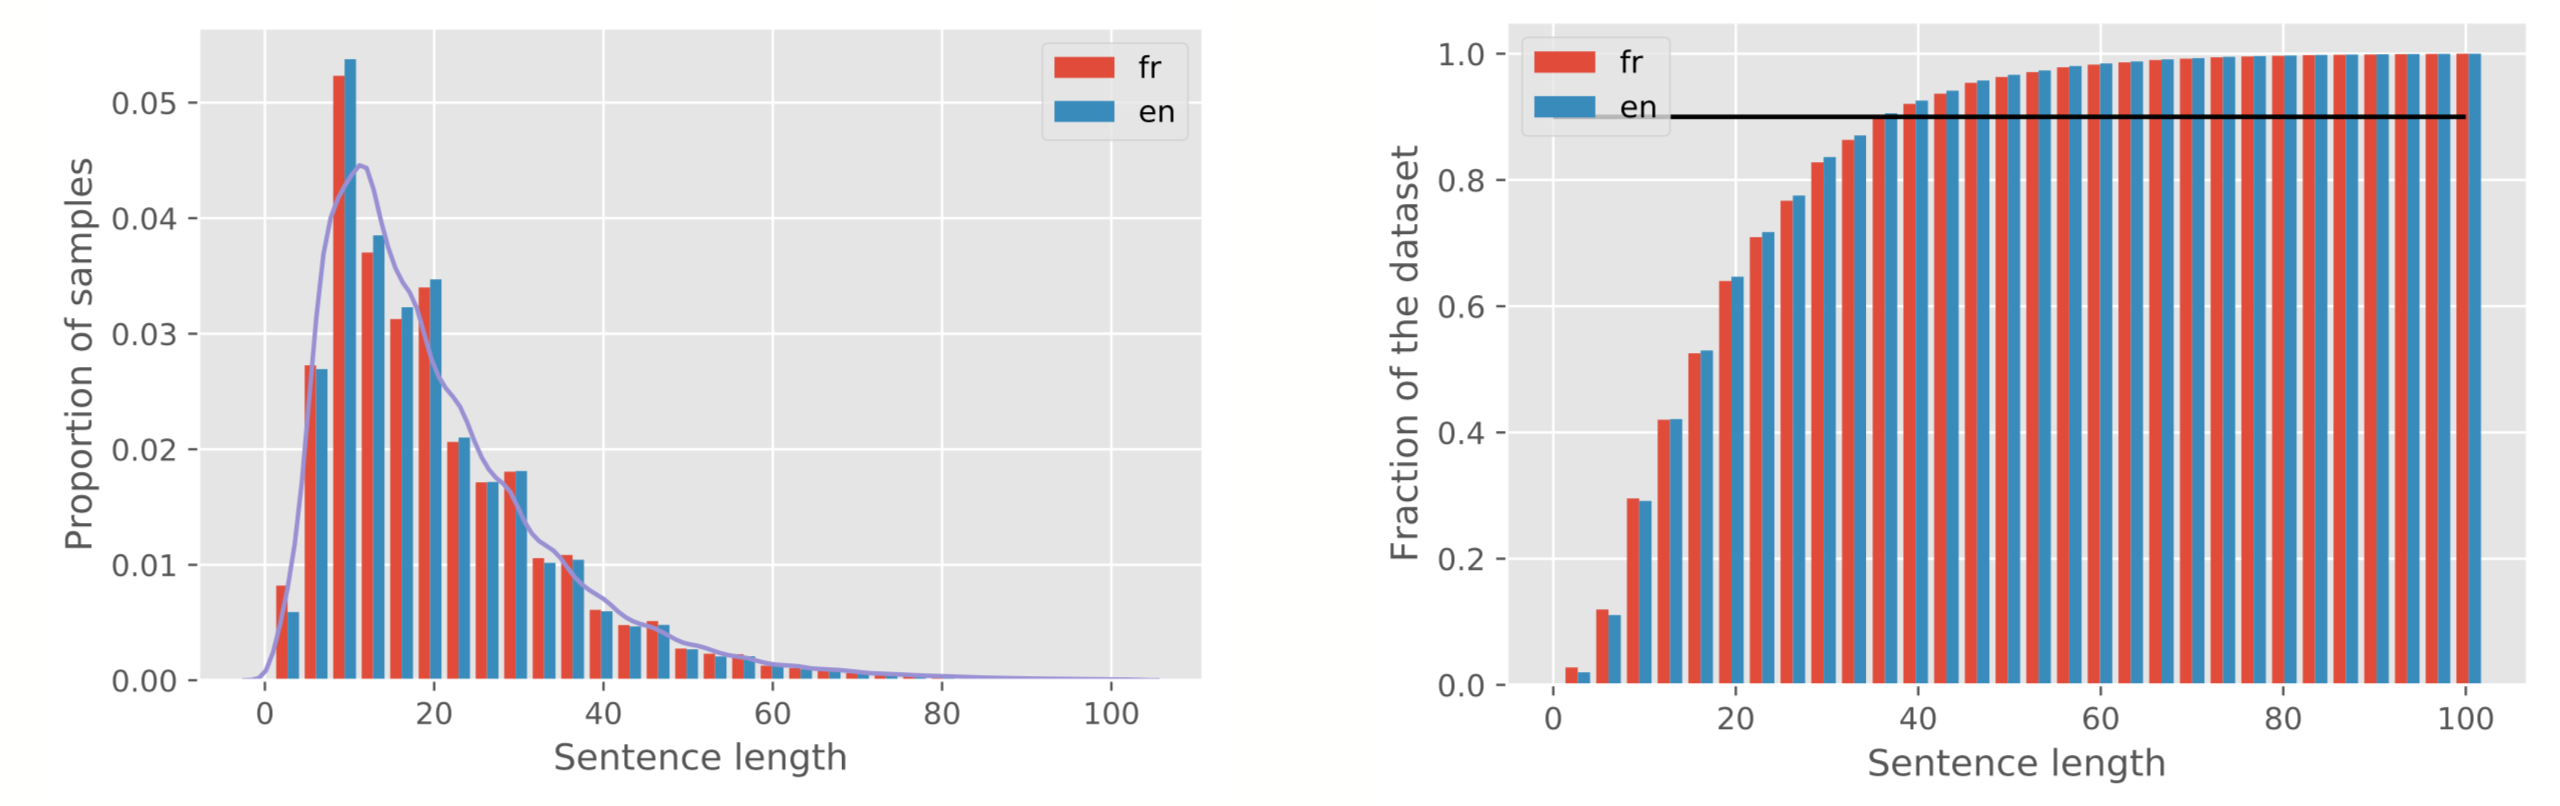</img>

<p style="text-align: center; font-weight: bold;">Figure 2: Histogram (normalized and cumulated) of the training set with respect to the sequence length.</p>

We can notice a long tailed dependency on the sequence length, meaning that for a sequence length of 40 (for a max of 102), we get 90% of the training set. A shorter sequence length provides the benefit of a larger batch size (for the same memory use), which generally stabilizes the training.

_What problems did you anticipate? What problems did you encounter?_


## Convergence issue

Having analyzed the dataset, we started by first running the model on 40% of the training set (corresponding to a sequence length of 18) for 15 epochs to observe if we could get convergence with the default hyper-parameters as indicated in the paper. We expected the validation loss to plateau, if not increase, which is what we observed:

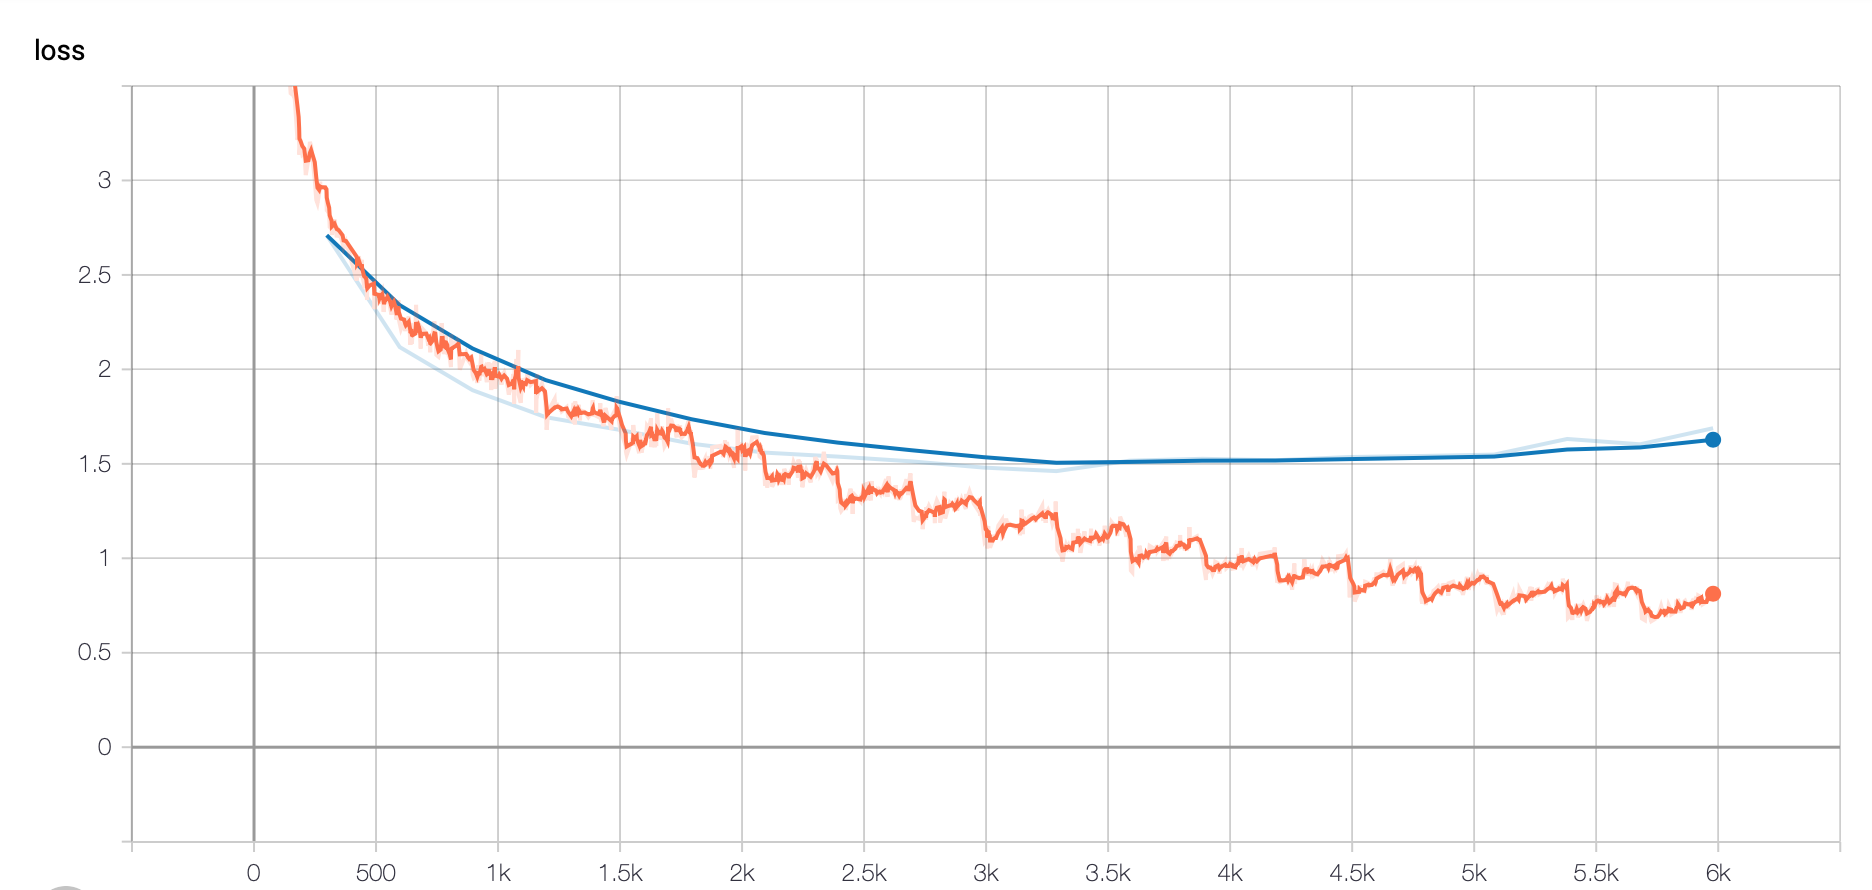</img>

<p style="text-align: center; font-weight: bold;">Figure 3: Training (orange) and validation (blue) loss evolution over 10 epochs on 40% of the training set.</p>

As can be seen, the validation loss clearly plateaus, and increases at the end of training, indicating an overfitting. Several causes could be pointed out here, such as a need for better regularization or more data.

Additionally, several hyper-parameters were present in the training, and we suspected that they would greatly influence the convergence of the model. We decided to perform a hyper-parameter search (using Google Cloud's [Hyperparameter Tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning) feature). 

We found a working combination of hyper-parameters and will analyze the training we obtained in the Experiments section.

_Is anything new in your approach?_

## Memory Use issue

Once the maximum sequence length fixed, we started experiments on GPUs. We quickly ran into issues of memory, the full model (6 layers in both the `Encoder` and `Decoder`) taking up a lot of space, leaving little for the batches, thus forcing a small batch size. 

To solve this issue, we profiled the memory usage of the model's forward pass, to see where the bottleneck was. We present the results in the next section and, to the best of our knowledge, this represents an analysis not previously done for the `Transformer`.

To address the issue, we also:
- pinned the generation of the datasets to CPU, and only move the batch to CUDA memory when needed,
- Implemented multi-gpu support. This allows a larger batch (e.g. of size 4\*128 = 512) to be split on several GPUs, each receiving a chunk of the batch (e.g. 128 samples for 4 GPUs). Yet, this only partially solves the issue, as according to our understanding, one of the GPU devices behaves as the master node and thus sees a higher memory usage as it computes gradients and backpropagates them. The other GPUs (behaving as slave nodes) are only used for computing a forward pass. This may be linked to a `PyTorch` limitation.

# Experiments and Results

_How did you measure success? What experiments were used? What were the results, both quantitative and qualitative? Did you succeed? Did you fail? Why?_

We present here our experiments and results.

# 

#### (?talk about the difference of workflow between training and testing?)

#### On a quantitative point of view, the loss (for both training and validation) is a good indicator of how well the model does; we used KL-divergence.
#### (?show Tensorboard plots?)
#### (?show visuals from poster?)

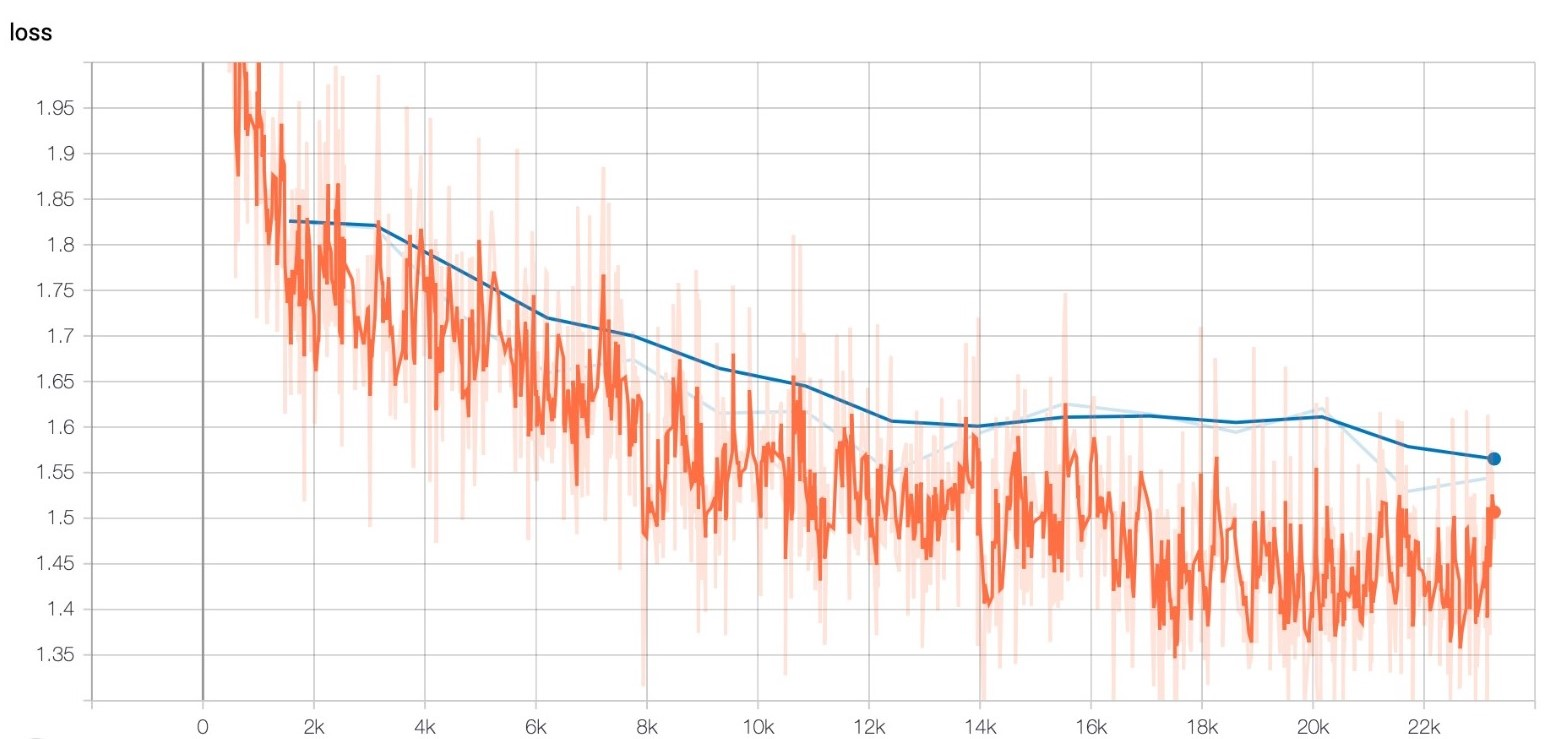</img>

<p style="text-align: center; font-weight: bold;">Figure 4: Training (orange) and validation (blue) loss evolution over 15 epochs on 90% of the training set.</p>

# In addition, 20 more points will be distributed based on presentation quality and Deep Learning knowledge

(5 points) Appropriate use of visual aids. Are the ideas presented with appropriate illustration? Is the problem effectively visualized? Is the approach visualized appropriately? Are the results presented clearly; are the important differences illustrated? Every section and idea does not need a visual aid, but the most interesting and complex parts of the project should be illustrated.

(5 points) Overall clarity. Is the presentation clear? Can a peer who has also taken Deep Learning understand all of the points addressed above? Is sufficient detail provided?

(10 points) Finally, points will be distributed based on your understanding of how your project relates to Deep Learning. Here are some questions to think about:

- What was the structure of your problem? How did the structure of your model reflect the structure of your problem?
- What parts of your model had learned parameters (e.g., convolution layers) and what parts did not (e.g., post-processing classifier probabilities into decisions)?
- What representations of input and output did the neural network expect? How was the data pre/post-processed?
What was the loss function?
- Did the model overfit? How well did the approach generalize?
- What hyperparameters did the model have? How were they chosen? How did they affect performance? What optimizer was used?
- What Deep Learning framework did you use?
- What existing code or models did you start with and what did those starting points provide?


we managed to get close to the original paper's results with limited hardware and time. This project then proves the accessibility of such a complex model (?to finish?)

# Analysis

Do the results make sense? Why or why not? Describe what kind of visualization/analysis you performed in order to verify that your results 1) are correct and 2) explain differences in performance from what was expected (e.g. what appeared in papers). Provide specific claims about why you think your model is or is not doing better, and justify those with qualitative and quantitative experiments (not necessarily just final accuracy numbers, but statistics or other data about what the model is doing).

Nemo enim ipsam voluptatem quia voluptas sit aspernatur aut odit aut fugit, sed quia consequuntur magni dolores eos qui ratione voluptatem sequi nesciunt. 

# Team Member Identification
Provide a list of team members and what each member did in a table. When an algorithm was implemented, provide specifics as to which parts your team member implemented and which parts were leveraging open-source code. Your project should include doing something beyond just downloading open-source code and tuning hyper-parameters. This can include implementation of additional approaches (if leveraging open-source code), theoretical analysis, or a thorough investigation of some phenomena. When using external resources, provide references to anything you used in the README!

Name	Description of Work
Team member 1	Implemented new loss function, trained and monitored the optimization addressing any issues such as overfitting, tuned hyper-parameters for new loss
Team member 2	Designed and implemented attentional mechanism for approach, trying out different approaches such as dot product attention.